In [29]:
import cv2
#openCV
import numpy as np
from scipy.stats import kurtosis,skew
#scipy is the statistical elder brother of numpy
import os
#os helps in fetching files from different directories i.e. communication with the operating system

In [30]:
def get_flow_patches(flow,boxes,idx):
    #Extract a patch in the image corresponding to the object's bounding box in the frame.
    flows=[]
    if len(idx)>0:
        for i in idx.flatten():
            center_x,center_y,w,h=boxes[i]
            # Using the center x, y coordinates to derive the top
            # and the left corner of the bounding box
            x=int(center_x-(w/2))
            y=int(center_y-(h/2))
            ##
            #The following is done to deal with typical situation when x or y are going out of frame
            #i.e not whole bounding box in the frame
            
            #stores part of the width to be cropped which is out of frame
            subx=0
            #stores part of the height to be cropped which is out of frame
            suby=0
            
            if x<0 or x>=flow.shape[1]:
                subx=x if x<0 else -1*x
                x=0 if x<0 else flow.shape[1]-1
            if y<0 or y>=flow.shape[0]:
                suby=y if y<0 else -1*y
                y=0 if y<0 else flow.shape[0]-1
            ##
            flows.append(flow[y:y+int(h)+suby,x:x+int(w)+subx,:])
    return flows       

In [31]:
# returns a deep learning network using the yolov4 format
net = cv2.dnn.readNet('yolov4.weights', 'yolov4.cfg')
# cv2.dnn.readNet=>https://docs.opencv.org/3.4/d6/d0f/group__dnn.html#ga3b34fe7a29494a6a4295c169a7d32422
# type net=Net object=>https://docs.opencv.org/3.4/db/d30/classcv_1_1dnn_1_1Net.html

In [32]:
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

In [33]:
def frames_process(frames_path, feature_matrix):
    frame_prev=None
    #print("hello!")
    for img in os.listdir(frames_path):
        
        if img.endswith(".jpg"):
            image_path=os.path.join(frames_path,img)
            # for running optical flow algorithm we need previous frame as well
            if frame_prev is None:
                frame_prev=cv2.imread(image_path)
                #imread->https://www.geeksforgeeks.org/python-opencv-cv2-imread-method/
                continue
            
            frame=cv2.imread(image_path)
            
            (height, width, _) = frame.shape
            
            #APPLYING OPTICAL FLOW ON THE FRAMES
            #Preprocessing to gray scale
            prvs=cv2.cvtColor(frame_prev,cv2.COLOR_BGR2GRAY)
            curr=cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
            #Dense optical flow algorithm
            flow=cv2.calcOpticalFlowFarneback(prvs, curr, None, 0.5, 3, 15, 3, 5, 1.2, 0)
            
            # RUNNING YOLOv4 OBJECT DETECTION 
            # preprocessing the frame before feeding it to the neural net.
            # scale the pixel values to 1/255=>1/255
            # Resizing frame to (416,416) pixels as yolov4 architecture works on frame of that size.
            # No mean supplied to the three R,G,B channels=>(0,0,0)
            # OpenCV assumes images are in BGR channel order, thus we must swap the R and B channels of the original RGB frame=> swapRB=true
            # No cropping of the frame=>crop=False
            blob = cv2.dnn.blobFromImage(frame,1 / 255,(416, 416),(0, 0, 0),swapRB=True,crop=False)
            # above parameters are needed for yolov4 detection!
            # cv2.dnn.blobFromImage=> creates processed 4-dimensional blob for use in our neural net.Further info=> https://www.pyimagesearch.com/2017/11/06/deep-learning-opencvs-blobfromimage-works/

            # setting input to neural net
            net.setInput(blob)

            # net.getUnconnectedOutLayers(): It gives you the final layers number in the list from net.getLayerNames().
            output_layer_names = net.getUnconnectedOutLayersNames()

            # Runs forward pass to compute output of layer with name outputName
            layerOutputs = net.forward(output_layer_names)

            # model output=>https://stackoverflow.com/questions/57112038/yolo-v3-model-output-clarification-with-keras
            # There are 3 output layers in YOLO for 3 different resolutions of grid boxes over which object is detected(13,13)(26,26)(52,52)

            # boxes stores the location properties of detected objects
            # confidences stores the confidence score of detecting that object

            boxes = []
            confidences = []
            appearance = []

            # traversing through the 3 outputs at varying resolution

            for output in layerOutputs:
                for detection in output:
                    # detection holds the location(first 5 elements) and class probabilities(rest 80 elements)
                    scores = detection[5:]

                    # selecting the index of maximum class probabilty of total 80 classes and its probability value as well

                    class_id = np.argmax(scores)
                    confidence = scores[class_id]

                    # check to filter objects we are entirely sure belong to some class

                    if confidence > 0.6:

                        # Extracting the center coordinates of the bounding box
                        # we need to convert back to original dimensions thus multiply by width,height is important
                        # print(detection[0])

                        center_x = detection[0] * width
                        center_y = detection[1] * height

                        # extracting the width and height of bounding box

                        w = detection[2] * width
                        h = detection[3] * height
                        boxes.append([center_x, center_y, w, h])
                        confidences.append(float(confidence))
                        appearance.append(scores)

            indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.6, 0.4)

            # NMSBoxes=>https://towardsdatascience.com/non-maximum-suppression-nms-93ce178e177c

            i = 0
            if boxes != []:
                # extract flow ptached corresponsing to bounding box coordinates for detected objects
                flows=get_flow_patches(flow,boxes,indexes)
                
                if flows!=[]:
                    for flow_patch in flows:
                        mag, _ = cv2.cartToPolar(flow_patch[..., 0], flow_patch[..., 1])
                        
                        #computing mean, variance, kurtosis and skew of the magnitude of velocity vectors
                        #motion metric
                        mean=np.mean(mag)
                        variance=np.var(mag)
                        kurtosis_=kurtosis(mag,None)
                        skew_=skew(mag,None)
                        
                        #location metric
                        cx,cy,wi,hi=boxes[indexes.flatten()[i]]
                        
                        #appearance[indexes.flatten()[i]]-> appearance metric
                        
                        #now creating feature vector for the object and appending feature vector of given object to feature matrix along with their weight
                        feature_matrix.append([mean,variance,kurtosis_,skew_]+[0.4*cx,0.4*cy,0.4*wi*hi]+list(0.9*appearance[indexes.flatten()[i]]))
                        
                        i=i+1
               

            # updating previous frame

            frame_prev = frame
        
    cv2.destroyAllWindows()

        

In [34]:
def vid_process(video_path,feature_matrix):
    #get video capture object for the camera for the specified video file 
    cap=cv2.VideoCapture(video_path)
    
    #Sometimes, cap may not have initialized the capture. 
    #You can check whether it is initialized or not by the method cap.isOpened().
    if(cap.isOpened()==False): 
        print("Error connecting to camera")
        return -1
    
    #for running optical flow algorithm we need previous frame as well
    ret,frame_prev=cap.read()
    #cap.read() returns a bool (True/False) which is stored in "ret" here. 
    #If the frame is read correctly, it will be True    
    
    if ret==False:
        print("Error loading frame")
        return
    while cap.isOpened():
        
        ret,frame=cap.read()
        
        if ret:
            #storing original frame dimensions
            height,width,_=frame.shape
            
            #APPLYING OPTICAL FLOW ON THE FRAMES
            #Preprocessing to gray scale
            prvs=cv2.cvtColor(frame_prev,cv2.COLOR_BGR2GRAY)
            curr=cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
            #Dense optical flow algorithm
            flow=cv2.calcOpticalFlowFarneback(prvs, curr, None, 0.5, 3, 15, 3, 5, 1.2, 0)
            
            #RUNNING YOLOv4 OBJECT DETECTION now
            #preprocessing the frame before feeding it to the neural net. 
            #scale the pixel values to 1/255=>1/255
            #Resizing frame to (416,416) pixels as yolov4 architecture works on frame of that size.
            #No mean supplied to the three R,G,B channels=>(0,0,0)
            #OpenCV assumes images are in BGR channel order, thus we must swap the R and B channels of the original RGB frame=> swapRB=true
            #No cropping of the frame=>crop=False
            blob=cv2.dnn.blobFromImage(frame,1/255,(416,416),(0,0,0),swapRB=True,crop=False)
            #above parameters are needed for yolov4 detection!
            #cv2.dnn.blobFromImage=> creates processed 4-dimensional blob for use in our neural net.Further info=> https://www.pyimagesearch.com/2017/11/06/deep-learning-opencvs-blobfromimage-works/
            
            #setting input to neural net
            net.setInput(blob)
            
            #net.getUnconnectedOutLayers(): It gives you the final layers number in the list from net.getLayerNames().
            output_layer_names=net.getUnconnectedOutLayersNames()
            
            #Runs forward pass to compute output of layer with name outputName
            layerOutputs=net.forward(output_layer_names)
            #model output=>https://stackoverflow.com/questions/57112038/yolo-v3-model-output-clarification-with-keras
            #There are 3 output layers in YOLO for 3 different resolutions of grid boxes over which object is detected(13,13)(26,26)(52,52)
            
            #boxes stores the location properties of detected objects
            #confidences stores the confidence score of detecting that object
            boxes=[]
            confidences=[]
            appearance=[]
            
            #traversing through the 3 outputs at varying resolution
            for output in layerOutputs:
                for detection in output:
                    #detection holds the location(first 5 elements) and class probabilities(rest 80 elements)
                    scores=detection[5:]
                    #print(scores)
                    #selecting the index of maximum class probabilty of total 80 classes and its probability value as well
                    class_id=np.argmax(scores)
                    confidence=scores[class_id]
                    #check to filter objects we are entirely sure belong to some class
                    if(confidence>0.6):
                        #Extracting the center coordinates of the bounding box
                        #we need to convert back to original dimensions thus multiply by width,height is important
                        #print(detection[0])
                        center_x=detection[0]*width
                        center_y=detection[1]*height
                        #extracting the width and height of bounding box
                        w=detection[2]*width
                        h=detection[3]*height
                        boxes.append([center_x,center_y,w,h])
                        confidences.append(float(confidence))
                        appearance.append(scores)
            
            indexes=cv2.dnn.NMSBoxes(boxes,confidences,0.6,0.4)
            #NMSBoxes=>https://towardsdatascience.com/non-maximum-suppression-nms-93ce178e177c
            i=0
            if boxes!=[]:
                
                #extract flow area corresponsing to bounding box coordinates for detected objects
                flows=get_flow_patches(flow,boxes,indexes)
                if flows!=[]:
                    for flow_patch in flows:
                        mag, _ = cv2.cartToPolar(flow_patch[..., 0], flow_patch[..., 1])
                        #computing mean, variance, kurtosis and skew of the magnitude of velocity vectors
                        #motion metric
                        mean=np.mean(mag)
                        variance=np.var(mag)
                        kurtosis_=kurtosis(mag,None)
                        skew_=skew(mag,None)
                        #location metric
                        cx,cy,wi,hi=boxes[indexes.flatten()[i]]
                        #appearance[indexes.flatten()[i]]-> appearance metric
                        #now creating feature vector for the object and appending feature vector of given object to feature matrix along with their weight
                        feature_matrix.append([mean,variance,kurtosis_,skew_]+[0.4*cx,0.4*cy,0.4*wi*hi]+list(0.9*appearance[indexes.flatten()[i]]))
                        i=i+1
                        
                        
            #updating previous frame            
            frame_prev=frame
            key=cv2.waitKey(1)
            
            #cv2.waitKey([delay])=>The function waitKey waits for a key event infinitely and the delay is in milliseconds. waitKey(0) means forever.
            #For more details=>https://stackoverflow.com/questions/57690899/how-cv2-waitkey1-0xff-ordq-works
            
            #if pressed key has ASCII value 27 i.e q
            if(key==27):
                break
            
            #if len(indexes)>0:
            #for i in indexes.flatten():                        
            
        else:
            print("Error loading frame or End of frames")
            return
    cap.release()
    cv2.destroyAllWindows()
        

In [36]:
#TRAINING THE DATASET
train_vector=[]
#Getting the parent directory
parent_directory=os.path.dirname(os.getcwd())
#os.path.dirname() method in Python is used to get directory name from the specified path 
#i.e the directory that hold the current file
#Python method os.getcwd() returns current working directory of a process.
#For more info->https://www.geeksforgeeks.org/python-os-path-dirname-method/

#accesing the DATASET directory
direc=os.path.join(parent_directory,'Dataset')
#os.path.join-> https://www.geeksforgeeks.org/python-os-path-join-method/


#first using the AVENUE DATASET training videos 
curr_direc=os.path.join(direc,'Avenue Dataset','training_videos')
for filename in os.listdir(curr_direc):
    #os.listdir->https://www.geeksforgeeks.org/python-os-listdir-method/
    if filename.endswith(".avi"):
        vid_process(os.path.join(curr_direc,filename),train_vector)
        
#Using the SHANGAI TECH DATASET training videos
curr_direc=os.path.join(direc,'ShangaiTech_training','videos')
for filename in os.listdir(curr_direc):
    if filename.endswith(".avi"):
        vid_process(os.path.join(curr_direc,filename),train_vector)
        
#using the PEDESTRIAN training dataset
curr_direc=os.path.join(direc,'ped2','training','frames')
for subdirec in os.listdir(curr_direc):
    video_frames=os.path.join(curr_direc,subdirec)
    frames_process(video_frames,train_vector)    


KeyboardInterrupt: 

In [37]:
import numpy.matlib
def knndis(t,M2):
    #A vectorised implementation of finding KNN distance between a single point and the M2 matrix
    Mg=M2.shape[0]
    #this will replicate the feature vector of 't' Mg times columnwise. 
    #To subtract, transpose is taken to make it compatible
    #Sum is taken of each row
    
    dist=np.sqrt(np.sum((np.matlib.repmat(t,Mg,1) - M2)**2,1))
    #np.matlib.repmat->Repeat given matrix columnwise(mg) and rowise(1)-> https://numpy.org/doc/stable/reference/generated/numpy.matlib.repmat.html
    
    #sorting the distance according to ascending order
    np.sort(dist)
    
    #return the sum of first 10 neighbours i.e k=10
    return sum(dist[0:10])/10

In [38]:
#randomly shuffling the feature matrix
#print(train_vector)
np.random.shuffle(train_vector)
#random.shuffle-> shuffle contents of array inplace along the first axis of multi-array. 
#for more details->https://numpy.org/doc/stable/reference/random/generated/numpy.random.shuffle.html

#converting to np array for later modifications
train_feature_matrix=np.array(train_vector)
print(train_feature_matrix.shape)

(5554, 87)


In [39]:
#Keeps track of di for all object i. 
errors=list()

#as given in the paper, split the training dataset into M1 and M2. Here 20% of training dataset goes to M1. 
p1=int(train_feature_matrix.shape[0]*0.2)
p2=train_feature_matrix.shape[0]-p1

M1=train_feature_matrix[0:p1]
M2=train_feature_matrix[p1:None]

#Finding the KNN distance for all the points in M1
for i in range(p1):
    errors.append(knndis(M1[i],M2)) 
print(errors)

[1084.518682332006, 922.6876494239907, 1292.0684061763611, 671.7692640487379, 759.9380541892187, 2040.60555248011, 1441.709201936702, 1159.595716886812, 1110.4621364953657, 1404.842554083541, 846.7883023189431, 1035.280035845913, 2110.853646984042, 989.6722487767329, 691.0876903195609, 711.2403334345834, 758.4710872085864, 1259.2575495134474, 770.9951742206879, 790.5452219444927, 656.8005299219477, 950.6679157581106, 1071.2961867074705, 1762.8223469569464, 651.2343574453841, 667.7848700288745, 903.778867272644, 1412.607851249438, 726.9771727943961, 3101.393080509458, 1446.370969569807, 673.3825716881099, 1325.901513060863, 905.8769738320836, 821.9435439085789, 732.9558465570753, 1306.677328765401, 1954.5732419596457, 659.6257154390431, 700.7063900892055, 889.2942379330468, 1229.144526965361, 1042.9549966419909, 715.893637714112, 1441.899271503295, 1307.175833688894, 698.191553756637, 744.9592919074304, 2490.352653248982, 647.5511859108854, 654.837531404126, 1355.9164268764434, 664.5982

In [40]:
#Using base thresold as one where 90% of KNN distance is lesser
Base_lm = np.sort(errors)[int(len(errors)*0.7)]
print(Base_lm)

1156.8985881298709


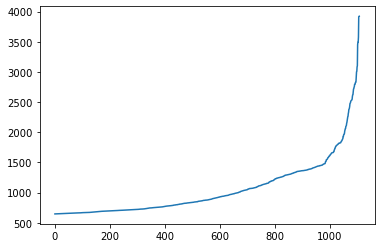

In [41]:
import matplotlib.pyplot as plt
#plotting the KNN distance
plt.plot(np.sort(errors)[1:1800])

In [ ]:
count = cv2.cuda.getCudaEnabledDeviceCount()
print(count)

In [ ]:
print(cv2.getBuildInformation())
